In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(420)
N = 500

In [2]:
def genTVSOAR(length, p, a0):
    ex = np.random.randn(length)

    A = np.zeros((N, p))
    omega, alpha = N/2, 0.1

    for n in range(N):
        A[n,0] = a0[0] + alpha * np.cos(2*np.pi*n/N)
        A[n,1] = a0[1] + alpha * 1.4*np.sin(6*np.pi*n/N)
    #implement new order here

    S = ex.copy();
    for n in range(p, N):
        x = np.array(S[slice(n-1, n-1-p if(n-1-p>=0) else None,-1)])
        S[n] = np.dot(x, A[n,:]) + ex[n]
        
    return S, A, ex

In [53]:
def ESS(w):
    ESS = [np.sum(w[:,t]**2)**-1 for t in range(N)]
    return ESS

def ESSPlot(w, n="ESSPlot"):
    plt.plot(ESS(w), label="ESS")
    plt.axhline(len(w), c='orange',label="L")
    plt.legend()
    plt.ylabel("Particles")
    plt.xlabel("Time index")
    plt.savefig(n)
    plt.show()
    
def ESSComp(w1, w2, n="ESSComp"):
    plt.plot(ESS(w1), label="ESS SIS")
    plt.plot(ESS(w2), label="ESS SIR")
    plt.axhline(len(w), c='red',label="L")
    plt.legend()
    plt.ylabel("Particles")
    plt.xlabel("Time index")
    plt.savefig(n)
    plt.show()
    
def scatter(fig, ax, x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    # r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    plt.scatter(x, y, c=color, **kwarg)
    
def weightDegPlot(w, n="DegPlot"):
    i = 1 
    a = np.linspace(0, N, N)
    s = np.zeros((len(w),len(w[0])))
    
    for t in range(len(w[0])):
        s[:,t] = w[:,t]/sum(w[:,t])
    
    fig, ax = plt.subplots(figsize=(20,5))

    for l in w:
        scatter(fig, ax, a, [i]*len(a), 'blue', s[i-1])
        i += 1
        
    ax.set_ylabel("Particle index")
    ax.set_xlabel("Time index")
    fig.savefig(n)
    fig.show()

In [35]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp 

class SIS:
    def __init__(self, phi, beta, varx, varz, x, L):
        self.phi = phi
        self.beta = beta
        self.varx = varx
        self.varz = varz
        self.x = x
        self.N = len(x)
        self.L = L
        
        self.w  = np.zeros((L,len(x)))
        self.z  = np.zeros((L,len(x)))
    
    def run(self, resample=False):
        #copy for local work
        wc = self.w.copy()
        z = self.z.copy()

        pred = np.zeros(self.N)

        mu = np.zeros(self.L)
        logw = np.zeros(self.L)
        
        for t in range(1, self.N):
            z[:,t] = self.phi * z[:,t-1] + np.sqrt(self.varz) * np.random.randn(self.L)     
            
            mu = self.beta * mu + z[:,t]
            
            logw += norm.logpdf(self.x[t], mu, np.sqrt(self.varx))
            
            wt = np.exp(logw - logsumexp(logw))
  
            pred[t] = np.dot(wt,z[:,t])
    
            wc[:,t] = wt #logging before resample weights
        
            if(resample):
                (wt, z[:,t]) = self.resample(wt, z[:,t])
                
                logw = np.log(wt) #reset log of weights with new resampled weights
        self.w = w
        self.z = z
        
        return (pred, wc, z)
    
    def resample(self, w, y):
        L = len(w)
        
        s = np.zeros(L)
        u = np.zeros(L)
        c = np.zeros(L)
        i = 1
        
        u[0] = np.random.uniform(0, (1/L))
        
        for l in range(1,L):
            c[l] = c[l-1] + w[l-1]
            u[l] = u[l-1] + (1/L)

        for l in range(L):
            while(i != L and u[l] > c[i]):
                i += 1
            s[l] = y[i-1]
        w = np.ones(L)/L    
        return (w,s)
    
    def resampling(self,w,z):
        N = w.shape[0]
        u = (np.arange(N) + np.random.rand(N))/N
        bins = np.cumsum(w)
        return (np.ones(N)/N, z[np.digitize(u, bins)])

In [56]:
N = 100
L = 50
a0 = np.array([0.4, -0.2])
S, A, ex = genTVSOAR(N, 2, a0)

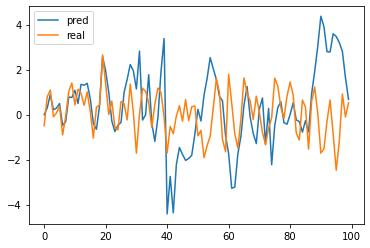

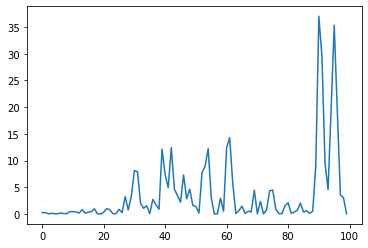

3.741319346054498


<ipython-input-53-4141a0abe8e2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  ESS = [np.sum(w[:,t]**2)**-1 for t in range(N)]


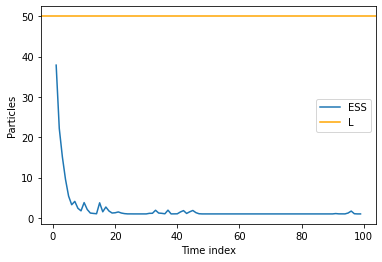

<ipython-input-53-4141a0abe8e2>:36: RuntimeWarning: invalid value encountered in true_divide
  s[:,t] = w[:,t]/sum(w[:,t])
<ipython-input-53-4141a0abe8e2>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


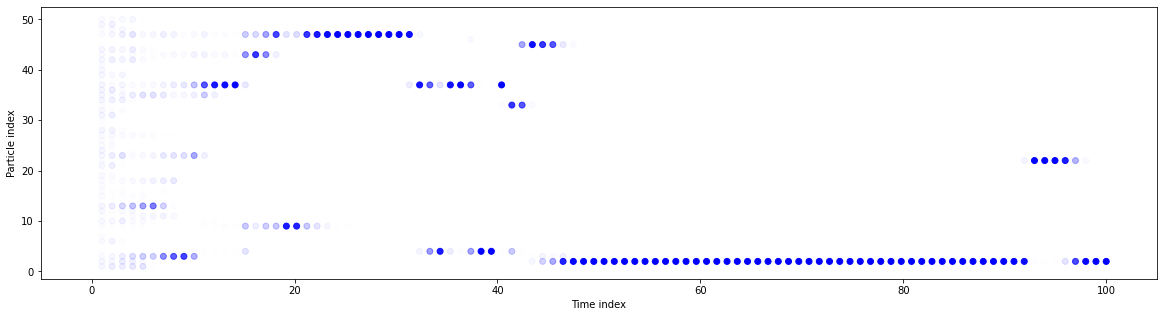

In [73]:
from matplotlib.colors import to_rgb, to_rgba

sis = SIS(1,0.01,0.9,0.9,S, L)
(pSIS, w, z) = sis.run()

plt.plot(pSIS, label="pred")
plt.plot(S, label="real")
plt.legend()
plt.savefig("SIS.png")

plt.show()
plt.plot((np.square(pSIS - S)))
plt.show()
print((np.square(pSIS - S)).mean(axis=0))

ESSPlot(w)
weightDegPlot(w)

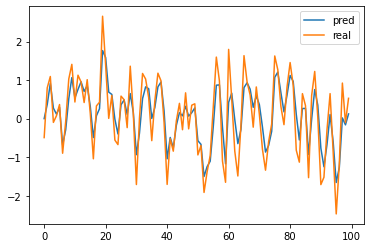

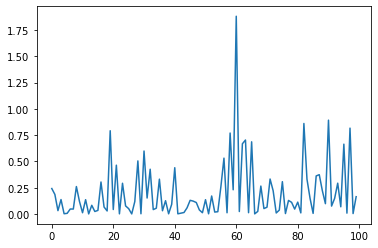

0.20256314611578496


<ipython-input-53-4141a0abe8e2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  ESS = [np.sum(w[:,t]**2)**-1 for t in range(N)]


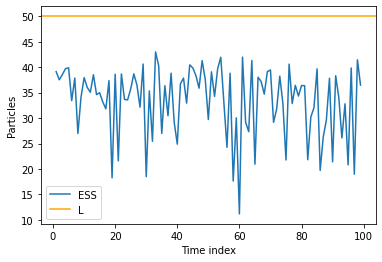

<ipython-input-53-4141a0abe8e2>:36: RuntimeWarning: invalid value encountered in true_divide
  s[:,t] = w[:,t]/sum(w[:,t])
<ipython-input-53-4141a0abe8e2>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


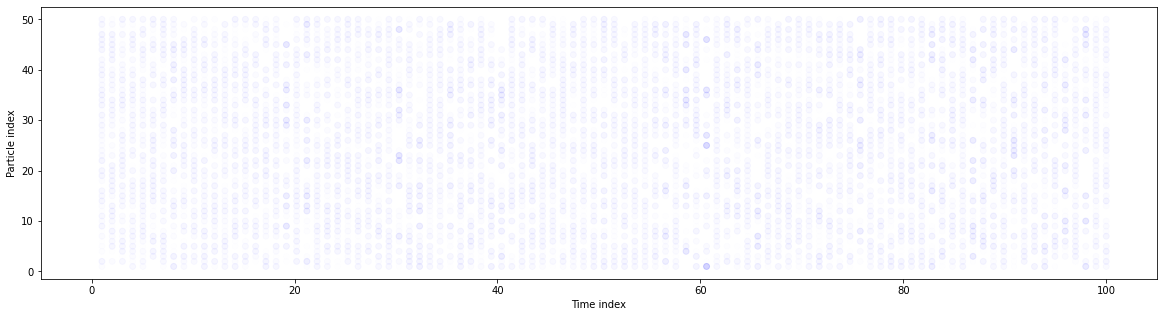

In [74]:
sis = SIS(1,0.01,0.9,0.9,S, L)
(pSIR, w2, z) = sis.run(resample=True)

plt.plot(pSIR, label="pred")
plt.plot(S, label="real")
plt.legend()
plt.savefig("SIR.png")

plt.show()
plt.plot((np.square(pSIR - S)))
plt.show()
print((np.square(pSIR - S)).mean(axis=0))

ESSPlot(w2, "ESSPlotResample")
weightDegPlot(w2, "DegPlotResample")

<ipython-input-53-4141a0abe8e2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  ESS = [np.sum(w[:,t]**2)**-1 for t in range(N)]


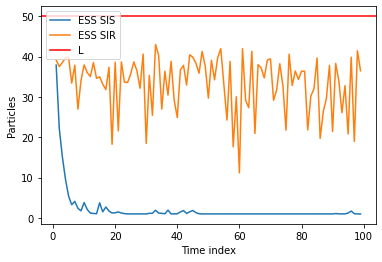

In [75]:
ESSComp(w,w2)

In [76]:
import numpy as np

class KalFilt:
       
    covLog = np.zeros([2,N])
    n=1
    
    def __init__(self, ps, R, eps, Qeps, th):
        self.theta = th
        self.psize = ps
        self.P = eps * np.identity(ps) 
        self.Q = Qeps * np.identity(ps) 
        self.R = R
        
        self.covLog[0,0] = self.theta[0].copy()
        self.covLog[1,0] = self.theta[1].copy()

        self.covLog[0,1] = self.theta[0].copy()
        self.covLog[1,1] = self.theta[1].copy()
    
    def predict_state(self):
        self.Pn1n1 = self.P.copy()
        self.P = self.P + self.Q
    
    def predict_point(self, x):
        return self.theta.T @ x
    
    def predict(self, x):
        self.predict_state()
        y = self.predict_point(x)
        return y
        
    def update(self, x, y):
        error = y - self.theta.T @ x
        k = (self.P @ x) / (R + x.T @ self.P @ x)
        
        self.theta += k * error
        self.P = (np.identity(self.psize) - k @ x.T) @ self.P
        
        self.n+=1
        self.covLog[0,n] = self.theta[0].copy()
        self.covLog[1,n] = self.theta[1].copy()
        
        return error

In [77]:
#KF parameters and initialisation
R = 0.1 * np.std(S[0:10]) # noise of dynamic function
eps = 0.001
Qeps = 0.001
theta = np.random.randn(2).reshape(-1,1)
kf = KalFilt(2, R, eps, Qeps, theta)

 #initialise var tracking
pKF = np.zeros(N)
es = np.zeros(N)
x = np.zeros((2,1))

#run KF on S
for n in range(2, N):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    pKF[n] = kf.predict(x)
    es[n] = np.linalg.norm(kf.update(x, S[n]))

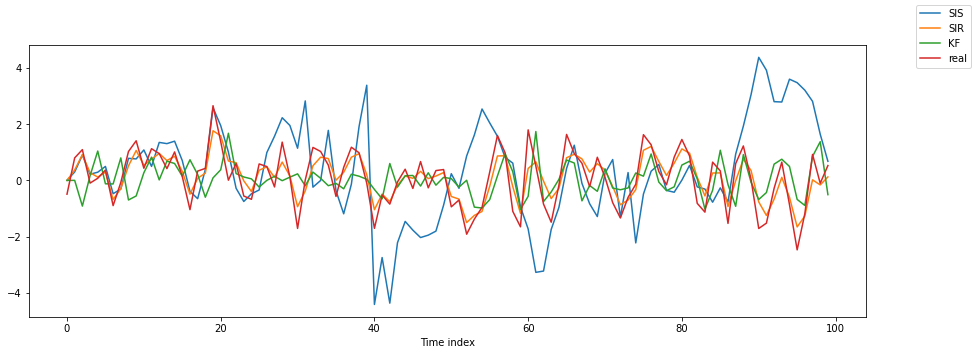

In [84]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(pSIS, label="SIS")
ax.plot(pSIR, label="SIR")
ax.plot(pKF, label="KF")
ax.plot(S, label="real")
ax.set_xlabel("Time index")
fig.legend()
fig.savefig("COMP.png")

In [83]:
print('SIS: ', (np.square(pSIS - S)).mean(axis=0))
print('SIR: ', (np.square(pSIR - S)).mean(axis=0))
print('KF: ', (np.square(pKF - S)).mean(axis=0))


SIS:  3.741319346054498
SIR:  0.20256314611578496
KF:  0.9540755743722774
